In [ ]:
# ------------------------- # 
#        SET - UP           # 
# ------------------------- # 

# ---- Requirements ----- # 

!pip install datasets
!pip install sentencepiece
!pip install transformers
!pip install rouge_score
!pip install bert_score 

from bert_score import score
from datasets import load_dataset, Dataset, load_metric
import sys
from google.colab import drive
import pandas as pd
import numpy as np
from transformers import BartForConditionalGeneration, BartTokenizer, DataCollatorForSeq2Seq, Seq2SeqTrainingArguments, Seq2SeqTrainer
import torch
import huggingface_hub
import matplotlib.pyplot as plt
import nltk
nltk.download("punkt")
import gc
from torch import nn 

# ----- Check if GPU is connected ----- # 
gpu_info = !nvidia-smi -L
gpu_info = "\n".join(gpu_info)
if gpu_info.find("failed") >= 0:
    print("Not connected to a GPU")
else:
    print(gpu_info)

# ----- Mounting Google Drive ----- # 

drive.mount('/content/drive')
sys.path.append('/content/drive/MyDrive/CIS6930_final')

# ----- Importing TweetSum processing module ----- #
from tweet_sum_processor import TweetSumProcessor

# ----- Torch Device ----- #
torch_device = 'cuda' if torch.cuda.is_available() else 'cpu'

# ----------------------------------------------------------------------

# --- DEFINE MODEL AND TOKENIZER --- #
model_name = "facebook/bart-large"
model = BartForConditionalGeneration.from_pretrained(model_name)
tokenizer = BartTokenizer.from_pretrained(model_name)

# ----- Metric
metric = load_metric("rouge")

# ---- Freeze parameters

def freeze_params(model: nn.Module):
    """Set requires_grad=False for each of model.parameters()"""
    for par in model.parameters():
        par.requires_grad = False

def freeze_embeds(model):
    """Freeze token embeddings and positional embeddings for BART and PEGASUS, just token embeddings for t5."""
    model_type = model.config.model_type
    if model_type == "t5":
        freeze_params(model.shared)
        for d in [model.encoder, model.decoder]:
            freeze_params(d.embed_tokens)
    else:
        freeze_params(model.model.shared)
        for d in [model.model.encoder, model.model.decoder]:
            freeze_params(d.embed_positions)
            freeze_params(d.embed_tokens)

freeze_embeds(model)

# ----- Reading in the Dataset
raw_datasets = load_dataset('csv', data_files={'train': '/content/drive/MyDrive/CIS6930_final/tweetsum_train.csv',
                                          'valid': '/content/drive/MyDrive/CIS6930_final/tweetsum_valid.csv',
                                          'test': '/content/drive/MyDrive/CIS6930_final/tweetsum_test.csv'})


In [2]:
max_input_length = 512
max_target_length = 128

def preprocess_function(examples):
    model_inputs = tokenizer(examples["inputs"], max_length=max_input_length, truncation=True)

    # Setup the tokenizer for targets
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(examples["summaries"], max_length=max_target_length, truncation=True)

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

tokenized_datasets = raw_datasets.map(preprocess_function, batched=True)

Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/default-a2b2b2c6b49c0494/0.0.0/bf68a4c4aefa545d0712b2fcbb1b327f905bbe2f6425fbc5e8c25234acb9e14a/cache-d53bc1267ca5d89b.arrow


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [3]:
batch_size = 1
args = Seq2SeqTrainingArguments(
    evaluation_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=3,
    predict_with_generate=True,
    fp16=True,
    push_to_hub=False,
    output_dir = '/content/drive/MyDrive/CIS6930_final/results/bart', 
    logging_dir = '/content/drive/MyDrive/CIS6930_final/logs/bart'
)

In [4]:


def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    # Replace -100 in the labels as we can't decode them.
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    
    # Rouge expects a newline after each sentence
    decoded_preds = ["\n".join(nltk.sent_tokenize(pred.strip())) for pred in decoded_preds]
    decoded_labels = ["\n".join(nltk.sent_tokenize(label.strip())) for label in decoded_labels]
    
    result = metric.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)
    # Extract a few results
    result = {key: value.mid.fmeasure * 100 for key, value in result.items()}
    
    # Add mean generated length
    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in predictions]
    result["gen_len"] = np.mean(prediction_lens)
    
    return {k: round(v, 4) for k, v in result.items()}

In [5]:
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

trainer = Seq2SeqTrainer(
    model,
    args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["valid"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)
trainer.train()

Using amp fp16 backend
The following columns in the training set  don't have a corresponding argument in `BartForConditionalGeneration.forward` and have been ignored: summaries, inputs.
***** Running training *****
  Num examples = 869
  Num Epochs = 3
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 2607


Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum,Gen Len
1,2.377300,1.981778,34.779600,15.935600,30.195000,32.655500,20.000000
2,1.657700,1.897160,34.448200,16.012400,30.044400,32.751200,20.000000
3,1.393900,1.900038,35.200000,16.427500,30.904900,33.357800,20.000000


Saving model checkpoint to /content/drive/MyDrive/CIS6930_final/results/bart/checkpoint-500
Configuration saved in /content/drive/MyDrive/CIS6930_final/results/bart/checkpoint-500/config.json
Model weights saved in /content/drive/MyDrive/CIS6930_final/results/bart/checkpoint-500/pytorch_model.bin
tokenizer config file saved in /content/drive/MyDrive/CIS6930_final/results/bart/checkpoint-500/tokenizer_config.json
Special tokens file saved in /content/drive/MyDrive/CIS6930_final/results/bart/checkpoint-500/special_tokens_map.json
Deleting older checkpoint [/content/drive/MyDrive/CIS6930_final/results/bart/checkpoint-1500] due to args.save_total_limit
The following columns in the evaluation set  don't have a corresponding argument in `BartForConditionalGeneration.forward` and have been ignored: summaries, inputs.
***** Running Evaluation *****
  Num examples = 108
  Batch size = 1
Saving model checkpoint to /content/drive/MyDrive/CIS6930_final/results/bart/checkpoint-1000
Configuration sa

TrainOutput(global_step=2607, training_loss=1.75626813729787, metrics={'train_runtime': 3172.5078, 'train_samples_per_second': 0.822, 'train_steps_per_second': 0.822, 'total_flos': 1713242213572608.0, 'train_loss': 1.75626813729787, 'epoch': 3.0})

# TESTING

In [6]:
# --------------------- # 
#    TEST EVALUATION    #
# --------------------- #

out = trainer.predict(tokenized_datasets["test"])
generated_summaries = []
for i in range(0, 110): 
  generated_summaries.append(tokenizer.decode(out[0][i], skip_special_tokens =  True))
ground_truth = tokenized_datasets["test"]["summaries"]
conversation = tokenized_datasets["test"]["inputs"]


The following columns in the test set  don't have a corresponding argument in `BartForConditionalGeneration.forward` and have been ignored: summaries, inputs.
***** Running Prediction *****
  Num examples = 110
  Batch size = 1


## ROUGE SCORES 

In [7]:
out.metrics

{'eval_gen_len': 19.9818,
 'eval_loss': 1.952686071395874,
 'eval_rouge1': 34.0362,
 'eval_rouge2': 15.1237,
 'eval_rougeL': 30.4906,
 'eval_rougeLsum': 32.1337,
 'eval_runtime': 132.2349,
 'eval_samples_per_second': 0.832,
 'eval_steps_per_second': 0.832}

## BART-SCORE

In [8]:
P, R, F1 = score(generated_summaries, ground_truth, lang="en", verbose=True)

Could not locate the tokenizer configuration file, will try to use the model config instead.
https://huggingface.co/roberta-large/resolve/main/config.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmp50q36ku2


Downloading:   0%|          | 0.00/482 [00:00<?, ?B/s]

storing https://huggingface.co/roberta-large/resolve/main/config.json in cache at /root/.cache/huggingface/transformers/dea67b44b38d504f2523f3ddb6acb601b23d67bee52c942da336fa1283100990.94cae8b3a8dbab1d59b9d4827f7ce79e73124efa6bb970412cd503383a95f373
creating metadata file for /root/.cache/huggingface/transformers/dea67b44b38d504f2523f3ddb6acb601b23d67bee52c942da336fa1283100990.94cae8b3a8dbab1d59b9d4827f7ce79e73124efa6bb970412cd503383a95f373
loading configuration file https://huggingface.co/roberta-large/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/dea67b44b38d504f2523f3ddb6acb601b23d67bee52c942da336fa1283100990.94cae8b3a8dbab1d59b9d4827f7ce79e73124efa6bb970412cd503383a95f373
Model config RobertaConfig {
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 1024,
  "initializer_r

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

storing https://huggingface.co/roberta-large/resolve/main/vocab.json in cache at /root/.cache/huggingface/transformers/7c1ba2435b05451bc3b4da073c8dec9630b22024a65f6c41053caccf2880eb8f.d67d6b367eb24ab43b08ad55e014cf254076934f71d832bbab9ad35644a375ab
creating metadata file for /root/.cache/huggingface/transformers/7c1ba2435b05451bc3b4da073c8dec9630b22024a65f6c41053caccf2880eb8f.d67d6b367eb24ab43b08ad55e014cf254076934f71d832bbab9ad35644a375ab
https://huggingface.co/roberta-large/resolve/main/merges.txt not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpsse4crnb


Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

storing https://huggingface.co/roberta-large/resolve/main/merges.txt in cache at /root/.cache/huggingface/transformers/20b5a00a80e27ae9accbe25672aba42ad2d4d4cb2c4b9359b50ca8e34e107d6d.5d12962c5ee615a4c803841266e9c3be9a691a924f72d395d3a6c6c81157788b
creating metadata file for /root/.cache/huggingface/transformers/20b5a00a80e27ae9accbe25672aba42ad2d4d4cb2c4b9359b50ca8e34e107d6d.5d12962c5ee615a4c803841266e9c3be9a691a924f72d395d3a6c6c81157788b
https://huggingface.co/roberta-large/resolve/main/tokenizer.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpcb3x8uyv


Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

storing https://huggingface.co/roberta-large/resolve/main/tokenizer.json in cache at /root/.cache/huggingface/transformers/e16a2590deb9e6d73711d6e05bf27d832fa8c1162d807222e043ca650a556964.fc9576039592f026ad76a1c231b89aee8668488c671dfbe6616bab2ed298d730
creating metadata file for /root/.cache/huggingface/transformers/e16a2590deb9e6d73711d6e05bf27d832fa8c1162d807222e043ca650a556964.fc9576039592f026ad76a1c231b89aee8668488c671dfbe6616bab2ed298d730
loading file https://huggingface.co/roberta-large/resolve/main/vocab.json from cache at /root/.cache/huggingface/transformers/7c1ba2435b05451bc3b4da073c8dec9630b22024a65f6c41053caccf2880eb8f.d67d6b367eb24ab43b08ad55e014cf254076934f71d832bbab9ad35644a375ab
loading file https://huggingface.co/roberta-large/resolve/main/merges.txt from cache at /root/.cache/huggingface/transformers/20b5a00a80e27ae9accbe25672aba42ad2d4d4cb2c4b9359b50ca8e34e107d6d.5d12962c5ee615a4c803841266e9c3be9a691a924f72d395d3a6c6c81157788b
loading file https://huggingface.co/robe

Downloading:   0%|          | 0.00/1.33G [00:00<?, ?B/s]

storing https://huggingface.co/roberta-large/resolve/main/pytorch_model.bin in cache at /root/.cache/huggingface/transformers/8e36ec2f5052bec1e79e139b84c2c3089cb647694ba0f4f634fec7b8258f7c89.c43841d8c5cd23c435408295164cda9525270aa42cd0cc9200911570c0342352
creating metadata file for /root/.cache/huggingface/transformers/8e36ec2f5052bec1e79e139b84c2c3089cb647694ba0f4f634fec7b8258f7c89.c43841d8c5cd23c435408295164cda9525270aa42cd0cc9200911570c0342352
loading weights file https://huggingface.co/roberta-large/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/8e36ec2f5052bec1e79e139b84c2c3089cb647694ba0f4f634fec7b8258f7c89.c43841d8c5cd23c435408295164cda9525270aa42cd0cc9200911570c0342352
Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias']
- This IS expected if you are ini

calculating scores...
computing bert embedding.


  0%|          | 0/4 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/2 [00:00<?, ?it/s]

done in 3.57 seconds, 30.79 sentences/sec


### SCORES

In [9]:
print(f"System level F1 score: {F1.mean():.3f}")
print(f"System level precision score: {P.mean():.3f}")
print(f"System level recall score: {R.mean():.3f}")

System level F1 score: 0.878
System level precision score: 0.895
System level recall score: 0.862


### VISUALIZATIONS

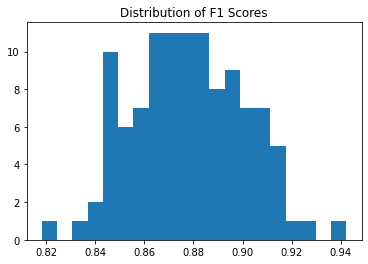

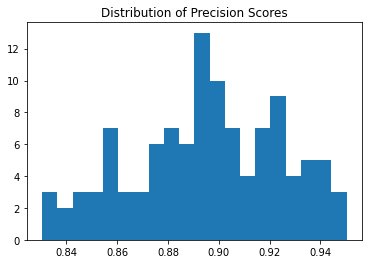

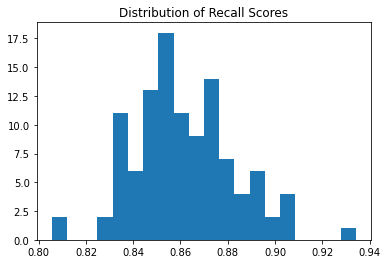

In [10]:
plt.hist(F1, bins=20)
plt.title("Distribution of F1 Scores")
plt.show()

plt.hist(P, bins=20)
plt.title("Distribution of Precision Scores")
plt.show()

plt.hist(R, bins=20)
plt.title("Distribution of Recall Scores")
plt.show()

## SAVE SUMMARIES TO CSV 

In [21]:
# ----- Mounting Google Drive ----- # 

drive.mount('/content/drive')
sys.path.append('/content/drive/MyDrive/CIS6930_final')
bart_summaries = pd.DataFrame({"candidate": generated_summaries, "reference": ground_truth, "conversation": conversation})
bart_summaries.to_csv('/content/drive/MyDrive/CIS6930_final/summaries/bart_test_summaries2.csv') 
print("Done")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Done
